# MSIN0097 - Predictive Analytics group assignment

In [1]:
import psycopg2 #requires installation
import pandas as pd

from tqdm import tqdm_notebook as tqdm #requires installation
conn = psycopg2.connect(
    database="ba_predictive", user='faculty',
    host='/var/run/postgresql'
)

conn.autocommit = True
cursor = conn.cursor()  

In [138]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from tqdm import tqdm_notebook as tqdm #requires installation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import os
!pip install pandas_profiling
from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)


In [3]:
# Set up output directory
current_directory =os.path.abspath(os.curdir)
print(current_directory)
output_folder = os.path.abspath(os.path.join("../Output"))
print(output_folder)

/project/Code
/project/Output


In [4]:
# Function to update observation_date
def modify_date(group):
    if len(group) == 1:
        group['observation_date'] = group['date_joined']
    else:
        group['observation_date'] = pd.date_range(start=group['date_joined'].iloc[0], periods=len(group), freq='MS')
    return group

In [5]:
# Define a function to impute missing values based on proportions
def impute_country(row):
    if pd.isna(row['country']):
        return np.random.choice(country_proportions.index, p=country_proportions.values)
    else:
        return row['country']

In [6]:
def cross_validation(X, y, lambdas, n_folds, regulariser):
    """
    Performs k-fold cross-validation for each lambda value and returns the mean squared error for each.
    """
    errors = []
    kf = KFold(n_splits=n_folds,shuffle=True, random_state=7)
    for l in lambdas:
        model = regulariser(alpha=l)
        fold_errors = []
        for train_index, val_index in kf.split(X):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_val, y_val = X.iloc[val_index], y.iloc[val_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            fold_errors.append(mean_squared_error(y_val, y_pred))
        errors.append(np.mean(fold_errors))
    return errors

### EDA of subscription & ChipIn information

In [7]:
# interesting tables
eda_tables = ['billing_upgradesubscription',# df_billing_us
'chipin_chipinplussubscriptiontier',        # df_chipin_cpst
'chipin_subscription',                      # df_chipin_s
'chipin_transaction',                       # df_chipin_t
'history_playhistory',                      # df_history_ph
'marketing_pushnotification',               # df_marketing_pn
'message_usermessagesettings',              # df_message_ums
'notifications_notifications',              # df_notifications_n
'studio_reward',                            # df_studio_r
'studio_song',                              # df_studio_s
'users_userprofile',                        # df_users_up 
'users_useriptrack',                        # df_user_track
'users_userlocation',                       # df_user_loc 
'users_usercurrentlocation',                # df_user_curloc 
'auth_user',                                 # df_auth_user
'users_registrationcountry',                # df_country
'users_useriptrack']                        # df_user_ip

In [8]:
ls_dfs = []
for table in tqdm(eda_tables):
    query = f'SELECT * FROM {table}'
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
    df_temp = pd.DataFrame(result)
    if df_temp.shape[0] > 0:
        cols = [col.name for col in cursor.description]
        df_temp.columns = cols
        df_temp.set_index(df_temp.columns[0], inplace=True)
        ls_dfs.append(df_temp)

/tmp/ipykernel_1515/3434313636.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for table in tqdm(eda_tables):


  0%|          | 0/17 [00:00<?, ?it/s]

In [9]:
# Let's explore specific tables in the database
df_billing_us         = ls_dfs[0].copy()
df_chipin_cpst        = ls_dfs[1].copy()
df_chipin_s           = ls_dfs[2].copy()
df_chipin_t           = ls_dfs[3].copy()
df_history_ph         = ls_dfs[4].copy()
df_marketing_pn       = ls_dfs[5].copy()
df_message_ums        = ls_dfs[6].copy()
df_notifications_n    = ls_dfs[7].copy()
df_studio_r           = ls_dfs[8].copy()
df_studio_s           = ls_dfs[9].copy()
df_users_up           = ls_dfs[10].copy()
df_user_track         = ls_dfs[11].copy()
df_user_loc           = ls_dfs[12].copy()
df_auth_user          = ls_dfs[14].copy()
df_country            = ls_dfs[15].copy()
df_user_ip            = ls_dfs[16].copy()

In [10]:
#df_user_loc.head()

In [11]:
#df_user_track.head()

In [12]:
#df_history_ph.head()

In [13]:
#df_studio_s.head(20)

In [14]:
df_users_up['chipin_plus_lock_all_songs'].value_counts()

False    17962
True        16
Name: chipin_plus_lock_all_songs, dtype: int64

In [15]:
df_users_up.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12637,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,
12776,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,
540,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,
8422,None,None,1997-01-16,,,None,None,None,,,,None,2021-02-24 02:48:30.344540+00:00,2021-02-24 02:49:56.424276+00:00,True,True,None,False,discover,NaN,NaN,NaN,8619,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,cus_J0Ds7ORytd3fov,NaN,web,5218021198069760,None,False,NaN,not_enabled,False,False,,NaT,ssh,
85,Blaine Neuhard,male,None,users/85/1b7abe60-460e-4c80-8ce2-fe592d2cce2a.jpg,,,None,None,None,None,None,,2020-11-18 15:03:31.561877+00:00,2021-02-10 22:39:30.976676+00:00,True,True,None,True,creator,NaN,NaN,NaN,85,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,1023.00,False,trackd,None,None,NaN,ios,5604270610120704,None,False,NaN,not_enabled,False,False,,NaT,ssh,


In [16]:
df_auth_user.head()

,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined
id,,,,,,,,,
6,bcrypt_sha256$$2b$12$tqU2Op6U0k/gV.xg0uMl8.Noy...,NaT,False,rachelayjay89,,,False,True,2020-11-18 15:02:57.928304+00:00
8648,!3QcFDJ3mnwNmoNyIUzafxiSI41iAS5wAk305e1nf,2022-01-28 05:25:07.979401+00:00,False,ownmus,Alex,Vish,False,True,2021-02-24 13:04:30.846037+00:00
8515,!8vh3LNN2u9HiwFxGvP7ZTygvcO2o9c49NhXl4Cxo,2021-02-21 16:34:08.663876+00:00,False,TBDpodcast,Blake,Juarez,False,True,2021-02-21 16:30:39.068049+00:00
11654,!ldjFSr04KYDa7VUTr0e69CRg9k4OWQbkA1ygrhfS,2021-07-10 06:39:05.949032+00:00,False,tee,Vinerva,Channel,False,True,2021-07-10 06:38:36.338523+00:00
8,bcrypt_sha256$$2b$12$xX6Mgge3W2ka1jMQEvpiD.zHq...,NaT,False,BeardedAudio,,,False,True,2020-11-18 15:02:58.665730+00:00


In [17]:
df_users_up['rc_product'].value_counts()

rc_promo_Access All Areas_three_month     139
com.tridentcloud.Trackd.7day.freetrial    104
com.tridentcloud.Trackd.1monthAAA          49
rc_promo_Access All Areas_yearly           32
rc_promo_Access All Areas_monthly          20
com.tridentcloud.Trackd.1monthAP           17
rc_promo_Access All Areas_lifetime         16
com.tridentcloud.Trackd.1months             9
rc_promo_Access All Areas_six_month         9
com.tridentcloud.Trackd.3months             4
com.tridentcloud.Trackd.12months            4
Name: rc_product, dtype: int64

In [18]:
df_users_up.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12637,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,
12776,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,
540,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,
8422,None,None,1997-01-16,,,None,None,None,,,,None,2021-02-24 02:48:30.344540+00:00,2021-02-24 02:49:56.424276+00:00,True,True,None,False,discover,NaN,NaN,NaN,8619,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,cus_J0Ds7ORytd3fov,NaN,web,5218021198069760,None,False,NaN,not_enabled,False,False,,NaT,ssh,
85,Blaine Neuhard,male,None,users/85/1b7abe60-460e-4c80-8ce2-fe592d2cce2a.jpg,,,None,None,None,None,None,,2020-11-18 15:03:31.561877+00:00,2021-02-10 22:39:30.976676+00:00,True,True,None,True,creator,NaN,NaN,NaN,85,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,1023.00,False,trackd,None,None,NaN,ios,5604270610120704,None,False,NaN,not_enabled,False,False,,NaT,ssh,


In [19]:
df_users_up[df_users_up['name']=='beansy']

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6331,beansy,female,1999-08-06,users/6519/a86bc9e7-9ada-4f7c-bfe7-cc6fc02ffba...,users/6519/e4672f58-1faf-4350-a19c-1b626ba73f1...,None,None,None,,sabinatingley,None,"Singer, songwriter",2020-12-22 13:55:41.491188+00:00,2022-09-07 20:54:35.270314+00:00,True,True,None,False,creator,2.00,NaN,161.00,6519,email,None,True,NaN,NaN,NaN,True,NaN,False,users/6519/5a3acb28-4fef-4004-8dc2-dbad4e76393...,,,,,users/6519/5cd735fb-55f6-4013-925b-46ac64832d5...,Sabina,tikitikioopla,True,116,acct_1I7MzNRB7vNdmGfC,pending,None,pending,None,False,None,True,True,NaN,True,trackd,None,None,NaN,ios,5490728988901376,rc_promo_Access All Areas_three_month,False,NaN,chipin,False,False,None,NaT,ssh,None


In [20]:
df_billing_us.head(50)

,amount,interval,status,currency,checkout_id,stripe_reference,expires_at,created_at,updated_at,user_id,account_type_id
id,,,,,,,,,,,
19,449.00,month,paid,usd,cs_live_a1VQlBY9LPzzWq8TDjKu4y2aBFwB3jZyTpIZDW...,sub_1KZzsWEkdC0auwbmxbbW2aq0,2022-12-05 15:50:44+00:00,2022-03-05 15:50:49.231041+00:00,2022-03-05 15:50:49.231058+00:00,16035,3
11,399.00,month,paid,usd,cs_live_a1S04NRRqxo7HkiLTnf93W4xlWfEAhDaZeoTyH...,sub_1K4G3DEkdC0auwbmX1yfa9bJ,2022-12-08 02:38:34+00:00,2021-12-08 02:38:38.186061+00:00,2021-12-08 02:38:38.186078+00:00,14368,4
21,399.00,month,cancelled,usd,cs_live_a1zCUqoRDebcXqH6bjWTHb0PfWbyr5eAFCAghh...,sub_1KeMTuEkdC0auwbmEFd3po2s,2022-05-17 16:47:22+00:00,2022-03-17 16:47:25.544294+00:00,2022-03-17 16:47:25.544308+00:00,16382,4
24,449.00,month,cancelled,usd,cs_live_a1XkGbadP424TdU56fiiMmREtwLvdeeqTsootx...,sub_1LCinREkdC0auwbmD4F50f9W,2022-08-20 11:29:33+00:00,2022-06-20 11:29:37.597888+00:00,2022-06-20 11:29:37.597902+00:00,15450,3
14,449.00,month,cancelled,usd,cs_live_a1fkTLD3KdFVub8VvxB859HS8zrJW4jC1RXUTp...,sub_1KRHu0EkdC0auwbmTHjm53Nf,2022-04-09 15:16:16+00:00,2022-02-09 15:16:23.083430+00:00,2022-02-09 15:16:23.083443+00:00,12864,3
18,449.00,month,cancelled,usd,cs_live_a1X0pIXQtUVahZaptfvVqfVUkWLhB7CfPB4Zfb...,sub_1KZuz9EkdC0auwbmbnjp9nqN,2022-07-05 10:37:15+00:00,2022-03-05 10:37:19.613518+00:00,2022-03-05 10:37:19.613532+00:00,16023,3
6,449.00,month,cancelled,usd,cs_live_a1wYNyH5n3J4ZSLxFbddBOtj3hr2HygTNEEsF5...,sub_1JvPgdEkdC0auwbmqTT67X8P,2022-08-13 17:06:43+00:00,2021-11-13 17:07:30.217259+00:00,2021-11-13 17:07:30.217273+00:00,12579,3
2,449.00,month,cancelled,usd,cs_live_a16TojtAhTJhQIUEovFo1jjFbuXk8XQFbn1qIY...,sub_K7K9xz5TnlXRYg,2021-11-27 13:54:18+00:00,2021-09-08 12:07:42.856141+00:00,2021-09-08 12:07:42.856153+00:00,12483,3
9,449.00,month,cancelled,usd,cs_live_a1KJjegBGvz73bbzcqcdcyHDRyVwuJwDwjOw3r...,sub_1K0rpeEkdC0auwbmhQF9wA9Z,2022-08-28 18:10:34+00:00,2021-11-28 18:10:38.048236+00:00,2021-11-28 18:10:38.048249+00:00,14188,3


In [21]:
df_billing_us.shape

(19, 11)

In [22]:
# This table doesn't appear to provide any useful information
df_chipin_cpst.head()

,name,price,active
id,,,
1,0.49,0.49,True
2,0.99,0.99,True
3,1.49,1.49,True
4,1.99,1.99,True
5,2.49,2.49,True


In [23]:
df_chipin_t.head()

,amount,status,stripe_reference,made_by_id,made_for_id,created_at,updated_at,thanked,currency,subscription_id,checkout_id,song_id,product_type
id,,,,,,,,,,,,,
2,500.00,processing,pi_1Hr3zHRPAEiF3usKhDRIv6Dv,6228.00,6236,2020-11-24 16:03:27.237582+00:00,2020-11-24 16:03:27.237604+00:00,False,gbp,NaN,None,None,chipin
1,500.00,paid,pi_1Hr3zGRPAEiF3usKUBfoeIfG,6228.00,6236,2020-11-24 16:03:26.461183+00:00,2020-11-24 16:03:26.461219+00:00,False,gbp,NaN,None,None,chipin
4,500.00,processing,pi_1HrNacRPAEiF3usKeALd4faI,6228.00,6236,2020-11-25 12:59:18.772214+00:00,2020-11-25 12:59:18.772236+00:00,False,gbp,NaN,None,None,chipin
5,500.00,processing,pi_1HrjrrRPAEiF3usKjrA95hDN,6228.00,6236,2020-11-26 12:46:35.838487+00:00,2020-11-26 12:46:35.838510+00:00,False,gbp,NaN,None,None,chipin
6,500.00,processing,pi_1Hs6zrRQD05jpdPaq1LqwbmA,6228.00,6233,2020-11-27 13:28:23.320203+00:00,2020-11-27 13:28:23.320226+00:00,False,gbp,NaN,None,None,chipin


In [24]:
df_chipin_s.head()

,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type
id,,,,,,,,,,,,,,
8,1000.00,month,processing,None,2020-12-16 15:16:54.751711+00:00,2020-12-16 15:16:54.751738+00:00,NaN,6238,False,False,gbp,cs_live_a1f5gcFW1BvCvM5OB7YZICgwB96bpPemznhXxf...,NaT,chipin
9,500.00,month,processing,None,2020-12-16 15:18:08.348781+00:00,2020-12-16 15:18:08.348814+00:00,NaN,6238,False,False,usd,cs_live_a1RfjddqprSXTFneEHGAENZl7ZRf340DlsYgDp...,NaT,chipin
10,2000.00,month,processing,None,2020-12-16 15:38:51.490828+00:00,2020-12-16 15:38:51.490851+00:00,NaN,6238,False,False,gbp,cs_live_a1F7PXTbSPZTi849QpaAaF4BHqJCcFNxkcTUbo...,NaT,chipin
11,500.00,month,processing,None,2020-12-16 23:03:58.271926+00:00,2020-12-16 23:03:58.271965+00:00,6317.00,6238,False,False,usd,None,NaT,chipin
12,1000.00,month,processing,None,2020-12-16 23:11:05.753955+00:00,2020-12-16 23:11:05.753990+00:00,6317.00,6236,False,False,usd,None,NaT,chipin


In [25]:
df_chipin_s['product_type'].value_counts()

chipin         65
chipin_plus    48
Name: product_type, dtype: int64

In [26]:
df_country.head()

,name,image,continent_id,country_code,currency_code,flag_image,stripe_enabled
id,,,,,,,
78,Pakistan,country/pakistan-g1f8621177_1280.png,3.00,PK,PKR,pakistan-g1f8621177_1280.png,False
117,Papua New Guinea,country/papua-new-guinea-g05d4f8367_1280.png,5.00,PG,PGK,papua-new-guinea-g05d4f8367_1280.png,False
50,Republic of Moldova,country/Flag_of_Moldova.png,1.00,MD,MDL,Flag_of_Moldova.png,False
250,Antarctica,country/antarctica-g22fc563ea_1280.png,4.00,AN,USD,antarctica-g22fc563ea_1280.png,False
10,Azerbaijan,country/azerbaijan-4866530_1280.png,1.00,AZR,AZN,azerbaijan-4866530_1280.png,False


In [27]:
#df_chipin_s.sort_values(['amount'],ascending= False, inplace= True)
df_chipin_s.loc[df_chipin_s.loc[:,'made_by_id']==6232.0].head(20)

,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type
id,,,,,,,,,,,,,,
19,2000.00,month,processing,None,2020-12-17 23:13:12.626993+00:00,2020-12-17 23:13:12.627019+00:00,6232.00,3446,False,False,usd,None,NaT,chipin
20,1000.00,month,processing,None,2020-12-17 23:17:40.792063+00:00,2020-12-17 23:17:40.792087+00:00,6232.00,2769,False,False,eur,None,NaT,chipin
39,2000.00,month,processing,None,2021-01-22 14:48:37.313357+00:00,2021-01-22 14:48:37.313384+00:00,6232.00,7246,False,False,gbp,None,NaT,chipin
41,2000.00,month,processing,None,2021-02-03 16:12:26.795027+00:00,2021-02-03 16:12:26.795051+00:00,6232.00,6845,False,False,usd,None,NaT,chipin
44,2000.00,month,processing,None,2021-03-04 15:36:28.084352+00:00,2021-03-04 15:36:28.084385+00:00,6232.00,6238,False,False,usd,None,NaT,chipin
50,5000.00,month,processing,None,2021-03-12 17:33:38.133774+00:00,2021-03-12 17:33:38.133801+00:00,6232.00,7568,False,False,gbp,None,NaT,chipin
54,2000.00,month,processing,None,2021-03-20 11:38:40.665897+00:00,2021-03-20 11:38:40.665919+00:00,6232.00,318,False,False,gbp,None,NaT,chipin
56,2000.00,month,processing,None,2021-03-25 16:56:36.278672+00:00,2021-03-25 16:56:36.278709+00:00,6232.00,52,False,False,usd,None,NaT,chipin
60,1000.00,month,processing,None,2021-04-02 19:59:06.137796+00:00,2021-04-02 19:59:06.137821+00:00,6232.00,1012,False,False,gbp,None,NaT,chipin


In [28]:
# Let's create a profiler report on the chipin subscription table
#profile = ProfileReport(df_chipin_s, title="ChipIn subscriptions")
#profile

In [29]:
#profile_subscription_t = ProfileReport(df_chipin_t, title="ChipIn subscription transactions")
#profile_subscription_t

In [30]:
#user_profile = ProfileReport(df_users_up, title="User table")
#user_profile

In [31]:
mean_amnt = df_chipin_s.groupby(['status']).mean()['amount']
display(mean_amnt)

/tmp/ipykernel_1515/4046082749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_amnt = df_chipin_s.groupby(['status']).mean()['amount']


status
cancelled         321.42
paid              448.69
processing   23775232.20
Name: amount, dtype: float64

/tmp/ipykernel_1515/70999381.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_amnt = df_chipin_s.groupby(['status']).mean()['amount']


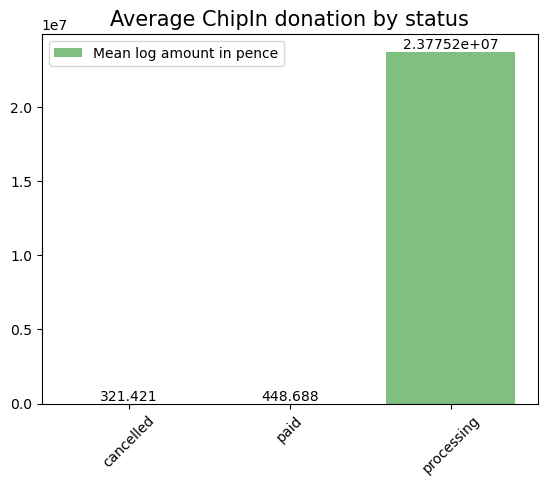

In [32]:
# Average amount by status
mean_amnt = df_chipin_s.groupby(['status']).mean()['amount']
bar_plot = plt.bar(mean_amnt.index, mean_amnt, color='g', alpha=0.5, label = 'Mean log amount in pence')
plt.bar_label(bar_plot)
plt.title('Average ChipIn donation by status', size=15)
plt.xticks(rotation = 45)
plt.legend()
plt.show()

/tmp/ipykernel_1515/799234548.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_log_amnt = df_chipin_s.groupby(['status']).mean()['log_amount']


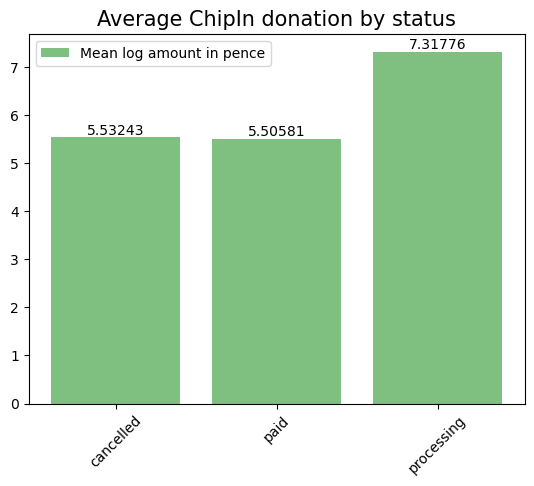

In [33]:
# Average amount by status
df_chipin_s['log_amount'] = np.log(df_chipin_s['amount'])
mean_log_amnt = df_chipin_s.groupby(['status']).mean()['log_amount']
bar_plot_log = plt.bar(mean_log_amnt.index, mean_log_amnt, color='g', alpha=0.5, label = 'Mean log amount in pence')
plt.bar_label(bar_plot_log)
plt.title('Average ChipIn donation by status', size=15)
plt.xticks(rotation = 45)
plt.legend()
#plt.ion()
plt.show()

Not clear why there are so many transactions with processing status and large amounts but in the absence of more informations, we will only consider those with paid status.

In [34]:
df_chipin_s_paid = df_chipin_s.copy()
df_chipin_s_paid = df_chipin_s_paid.loc[df_chipin_s_paid.loc[:,'status']=='paid']

In [35]:
df_chipin_s_paid.head(20)

,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount
id,,,,,,,,,,,,,,,
46,2000.00,month,paid,None,2021-03-05 20:16:56.868117+00:00,2021-03-05 20:16:56.868155+00:00,NaN,7246,False,False,gbp,cs_live_a1tMg61GrXwRePwSNbGFKliAQSpUAwjuhmtGTY...,NaT,chipin,7.60
92,500.00,month,paid,sub_K11cyIDngldptM,2021-08-10 18:20:26.757989+00:00,2021-08-31 15:51:57.754128+00:00,6232.00,9413,False,False,gbp,cs_live_a1Bo1bBkRQwyzJgHoQ4eWSkltuWNH9Kn4KY84X...,2022-11-10 18:20:23+00:00,chipin,6.21
93,200.00,month,paid,sub_K1NBgNoYjOEaVE,2021-08-11 16:37:37.675656+00:00,2021-08-31 15:51:59.110109+00:00,12075.00,7770,False,False,gbp,cs_live_a13abe0ZHVfj53rHB8Rt90sxDh9mOzZXzBOib1...,2022-11-11 16:37:34+00:00,chipin,5.30
80,1000.00,month,paid,sub_JpoVbkrWov0Zau,2021-07-11 20:03:40.912709+00:00,2021-08-31 15:52:00.507106+00:00,6232.00,3090,False,False,usd,cs_live_a1WqaQXfrTYehHnYWDZt1D8l3yRgvFZs1MZlkr...,2022-11-11 20:03:37+00:00,chipin,6.91
90,199.00,month,paid,sub_Ju0B8FwIySvtJM,2021-07-23 00:23:56.255585+00:00,2021-08-31 15:51:52.992076+00:00,6232.00,1012,False,False,gbp,cs_live_a1i9izuSxa5cLArp8OOy2PtiUTY02NUCsDygf6...,2022-11-23 00:23:53+00:00,chipin_plus,5.29
131,990.00,year,paid,sub_1KIziHRTL0mr5Bttyw4Vkplm,2022-01-17 18:13:57.334886+00:00,2022-01-17 18:13:57.334923+00:00,6232.00,9413,False,False,gbp,cs_live_a1ILLyX1PZWGVhPHzmHZbKYoqCQNeHEoO0xSER...,2023-01-17 18:13:53+00:00,chipin_plus,6.90
139,499.00,month,paid,sub_1LN0MBRKXq0wW8a0Rmjbddfo,2022-07-18 20:17:33.896786+00:00,2022-07-18 20:17:33.896798+00:00,11752.00,10670,False,False,usd,cs_live_a106HLdnh85W8Oe9Scq1LI0mvJxncoRB1SFYSz...,2022-11-18 20:15:55+00:00,chipin_plus,6.21
115,99.00,month,paid,sub_1Jm4LGRKpu9uOgcJGombQJmH,2021-10-18 22:30:06.453821+00:00,2021-10-18 22:30:06.453841+00:00,13473.00,7770,False,False,gbp,cs_live_a1NQEKsBTfSkdD1M2KnICrbjAHlQs26R6prnGW...,2022-11-18 22:30:02+00:00,chipin_plus,4.60
116,99.00,month,paid,sub_1JmcsFRKpu9uOgcJQUrT8xIe,2021-10-20 11:22:26.836141+00:00,2021-10-20 11:22:26.836156+00:00,9819.00,7770,False,False,gbp,cs_live_a1CQOaOHL97ZQL8tnfsGIBu8qIbpXnGcTsQJgO...,2022-11-20 11:22:23+00:00,chipin_plus,4.60


Although we cannot join this information to the user table because they are no appropriate keys to join, we can join with the **ChipIn transactions** table to estimate the monthly revenues for Trackd.

In [36]:
df_chipin_t.head()

,amount,status,stripe_reference,made_by_id,made_for_id,created_at,updated_at,thanked,currency,subscription_id,checkout_id,song_id,product_type
id,,,,,,,,,,,,,
2,500.00,processing,pi_1Hr3zHRPAEiF3usKhDRIv6Dv,6228.00,6236,2020-11-24 16:03:27.237582+00:00,2020-11-24 16:03:27.237604+00:00,False,gbp,NaN,None,None,chipin
1,500.00,paid,pi_1Hr3zGRPAEiF3usKUBfoeIfG,6228.00,6236,2020-11-24 16:03:26.461183+00:00,2020-11-24 16:03:26.461219+00:00,False,gbp,NaN,None,None,chipin
4,500.00,processing,pi_1HrNacRPAEiF3usKeALd4faI,6228.00,6236,2020-11-25 12:59:18.772214+00:00,2020-11-25 12:59:18.772236+00:00,False,gbp,NaN,None,None,chipin
5,500.00,processing,pi_1HrjrrRPAEiF3usKjrA95hDN,6228.00,6236,2020-11-26 12:46:35.838487+00:00,2020-11-26 12:46:35.838510+00:00,False,gbp,NaN,None,None,chipin
6,500.00,processing,pi_1Hs6zrRQD05jpdPaq1LqwbmA,6228.00,6233,2020-11-27 13:28:23.320203+00:00,2020-11-27 13:28:23.320226+00:00,False,gbp,NaN,None,None,chipin


In [37]:
# Similar to the subscriptions table, we'll only take the transactions with paid status as we assume that those with processing status
# would not have gone through so Trackd would not get a 5% share from them
df_chipin_t_paid = df_chipin_t.copy()
df_chipin_t_paid = df_chipin_t_paid.loc[df_chipin_t_paid.loc[:,'status']=='paid']

In [38]:
# Now we concatenate the two tables together
df_chipin_funds = pd.concat([df_chipin_s_paid, df_chipin_t_paid], axis=0)
df_chipin_funds.head()

,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id
id,,,,,,,,,,,,,,,,,
46,2000.00,month,paid,None,2021-03-05 20:16:56.868117+00:00,2021-03-05 20:16:56.868155+00:00,NaN,7246,False,False,gbp,cs_live_a1tMg61GrXwRePwSNbGFKliAQSpUAwjuhmtGTY...,NaT,chipin,7.60,NaN,NaN
92,500.00,month,paid,sub_K11cyIDngldptM,2021-08-10 18:20:26.757989+00:00,2021-08-31 15:51:57.754128+00:00,6232.00,9413,False,False,gbp,cs_live_a1Bo1bBkRQwyzJgHoQ4eWSkltuWNH9Kn4KY84X...,2022-11-10 18:20:23+00:00,chipin,6.21,NaN,NaN
93,200.00,month,paid,sub_K1NBgNoYjOEaVE,2021-08-11 16:37:37.675656+00:00,2021-08-31 15:51:59.110109+00:00,12075.00,7770,False,False,gbp,cs_live_a13abe0ZHVfj53rHB8Rt90sxDh9mOzZXzBOib1...,2022-11-11 16:37:34+00:00,chipin,5.30,NaN,NaN
80,1000.00,month,paid,sub_JpoVbkrWov0Zau,2021-07-11 20:03:40.912709+00:00,2021-08-31 15:52:00.507106+00:00,6232.00,3090,False,False,usd,cs_live_a1WqaQXfrTYehHnYWDZt1D8l3yRgvFZs1MZlkr...,2022-11-11 20:03:37+00:00,chipin,6.91,NaN,NaN
90,199.00,month,paid,sub_Ju0B8FwIySvtJM,2021-07-23 00:23:56.255585+00:00,2021-08-31 15:51:52.992076+00:00,6232.00,1012,False,False,gbp,cs_live_a1i9izuSxa5cLArp8OOy2PtiUTY02NUCsDygf6...,2022-11-23 00:23:53+00:00,chipin_plus,5.29,NaN,NaN


In [39]:
# Let's create a few new columns
trackd_share = 0.05
df_chipin_funds['Trackd_chipin_share'] = df_chipin_funds['amount'] * trackd_share
df_chipin_funds['chipin_rev'] = df_chipin_funds['Trackd_chipin_share']/100
df_chipin_funds['payment_date'] = pd.to_datetime(df_chipin_funds['created_at'], errors='raise')
df_chipin_funds['date'] = df_chipin_funds['payment_date'].dt.to_period('M')
df_chipin_funds['date'] = df_chipin_funds['date'].dt.to_timestamp()

/tmp/ipykernel_1515/2482921021.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_chipin_funds['date'] = df_chipin_funds['payment_date'].dt.to_period('M')


In [40]:
# We also need to convert revenue to a single currency (GBP)
# For simplicity we will take the average exchange rate between Nov 2020 and Oct 2022
df_chipin_funds['exchange_rate'] = np.where(df_chipin_funds['currency']=='eur', 0.8590, 
                                            np.where(df_chipin_funds['currency']=='usd', 0.7620, 1))
df_chipin_funds['chipin_rev_gbp'] =df_chipin_funds['chipin_rev'] * df_chipin_funds['exchange_rate']

/tmp/ipykernel_1515/357978712.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chipin_rev = df_chipin_funds.groupby(['date', 'product_type']).sum()['chipin_rev_gbp'].unstack()


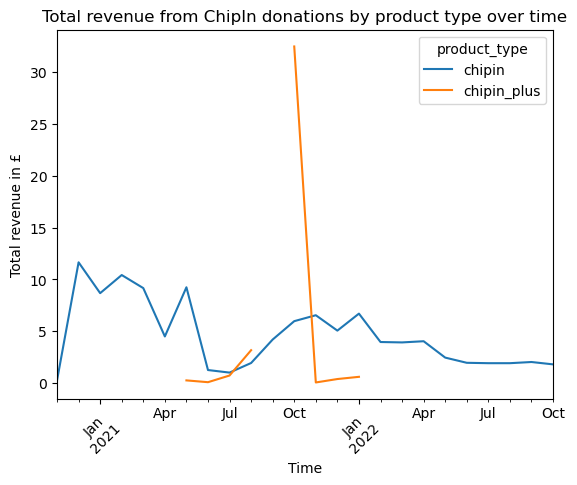

In [41]:
# Now let's plot the Trackd's historical revenue from ChipIn share
chipin_rev = df_chipin_funds.groupby(['date', 'product_type']).sum()['chipin_rev_gbp'].unstack()

#fig, ax = plt.subplots()
ax = chipin_rev.plot(kind='line')
ax.set_title('Total revenue from ChipIn donations by product type over time', size=12)
plt.xticks(rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Total revenue in £')
ax.set_label(['Chip In, Chip In+'])
plt.savefig(output_folder + '/ChipIn_revenue_over_time.png')
plt.show()

In [42]:
df_chipin_funds.head()

,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date,exchange_rate,chipin_rev_gbp
id,,,,,,,,,,,,,,,,,,,,,,,
46,2000.00,month,paid,None,2021-03-05 20:16:56.868117+00:00,2021-03-05 20:16:56.868155+00:00,NaN,7246,False,False,gbp,cs_live_a1tMg61GrXwRePwSNbGFKliAQSpUAwjuhmtGTY...,NaT,chipin,7.60,NaN,NaN,100.00,1.00,2021-03-05 20:16:56.868117+00:00,2021-03-01,1.00,1.00
92,500.00,month,paid,sub_K11cyIDngldptM,2021-08-10 18:20:26.757989+00:00,2021-08-31 15:51:57.754128+00:00,6232.00,9413,False,False,gbp,cs_live_a1Bo1bBkRQwyzJgHoQ4eWSkltuWNH9Kn4KY84X...,2022-11-10 18:20:23+00:00,chipin,6.21,NaN,NaN,25.00,0.25,2021-08-10 18:20:26.757989+00:00,2021-08-01,1.00,0.25
93,200.00,month,paid,sub_K1NBgNoYjOEaVE,2021-08-11 16:37:37.675656+00:00,2021-08-31 15:51:59.110109+00:00,12075.00,7770,False,False,gbp,cs_live_a13abe0ZHVfj53rHB8Rt90sxDh9mOzZXzBOib1...,2022-11-11 16:37:34+00:00,chipin,5.30,NaN,NaN,10.00,0.10,2021-08-11 16:37:37.675656+00:00,2021-08-01,1.00,0.10
80,1000.00,month,paid,sub_JpoVbkrWov0Zau,2021-07-11 20:03:40.912709+00:00,2021-08-31 15:52:00.507106+00:00,6232.00,3090,False,False,usd,cs_live_a1WqaQXfrTYehHnYWDZt1D8l3yRgvFZs1MZlkr...,2022-11-11 20:03:37+00:00,chipin,6.91,NaN,NaN,50.00,0.50,2021-07-11 20:03:40.912709+00:00,2021-07-01,0.76,0.38
90,199.00,month,paid,sub_Ju0B8FwIySvtJM,2021-07-23 00:23:56.255585+00:00,2021-08-31 15:51:52.992076+00:00,6232.00,1012,False,False,gbp,cs_live_a1i9izuSxa5cLArp8OOy2PtiUTY02NUCsDygf6...,2022-11-23 00:23:53+00:00,chipin_plus,5.29,NaN,NaN,9.95,0.10,2021-07-23 00:23:56.255585+00:00,2021-07-01,1.00,0.10


In [43]:
# Calculate the total revenue over the whole period from Chip In donations
print(df_chipin_funds['chipin_rev_gbp'].sum())
display(df_chipin_funds.groupby(['product_type']).sum()['chipin_rev_gbp'])

148.46201200000002


/tmp/ipykernel_1515/3722085758.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(df_chipin_funds.groupby(['product_type']).sum()['chipin_rev_gbp'])


product_type
chipin        110.49
chipin_plus    37.97
Name: chipin_rev_gbp, dtype: float64

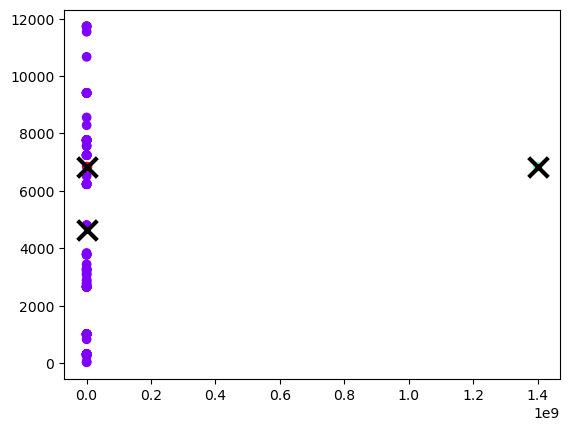

In [44]:
# Fit a k-means cluster
from sklearn.cluster import KMeans

X = df_chipin_s.loc[:,['amount','made_for_id']]
# Fit k-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Visualize the clustering result
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='black')
plt.show()

In [45]:
df_users_up.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12637,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,
12776,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,
540,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,
8422,None,None,1997-01-16,,,None,None,None,,,,None,2021-02-24 02:48:30.344540+00:00,2021-02-24 02:49:56.424276+00:00,True,True,None,False,discover,NaN,NaN,NaN,8619,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,cus_J0Ds7ORytd3fov,NaN,web,5218021198069760,None,False,NaN,not_enabled,False,False,,NaT,ssh,
85,Blaine Neuhard,male,None,users/85/1b7abe60-460e-4c80-8ce2-fe592d2cce2a.jpg,,,None,None,None,None,None,,2020-11-18 15:03:31.561877+00:00,2021-02-10 22:39:30.976676+00:00,True,True,None,True,creator,NaN,NaN,NaN,85,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,1023.00,False,trackd,None,None,NaN,ios,5604270610120704,None,False,NaN,not_enabled,False,False,,NaT,ssh,


In [46]:
df_chipin_funds.head()

,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date,exchange_rate,chipin_rev_gbp
id,,,,,,,,,,,,,,,,,,,,,,,
46,2000.00,month,paid,None,2021-03-05 20:16:56.868117+00:00,2021-03-05 20:16:56.868155+00:00,NaN,7246,False,False,gbp,cs_live_a1tMg61GrXwRePwSNbGFKliAQSpUAwjuhmtGTY...,NaT,chipin,7.60,NaN,NaN,100.00,1.00,2021-03-05 20:16:56.868117+00:00,2021-03-01,1.00,1.00
92,500.00,month,paid,sub_K11cyIDngldptM,2021-08-10 18:20:26.757989+00:00,2021-08-31 15:51:57.754128+00:00,6232.00,9413,False,False,gbp,cs_live_a1Bo1bBkRQwyzJgHoQ4eWSkltuWNH9Kn4KY84X...,2022-11-10 18:20:23+00:00,chipin,6.21,NaN,NaN,25.00,0.25,2021-08-10 18:20:26.757989+00:00,2021-08-01,1.00,0.25
93,200.00,month,paid,sub_K1NBgNoYjOEaVE,2021-08-11 16:37:37.675656+00:00,2021-08-31 15:51:59.110109+00:00,12075.00,7770,False,False,gbp,cs_live_a13abe0ZHVfj53rHB8Rt90sxDh9mOzZXzBOib1...,2022-11-11 16:37:34+00:00,chipin,5.30,NaN,NaN,10.00,0.10,2021-08-11 16:37:37.675656+00:00,2021-08-01,1.00,0.10
80,1000.00,month,paid,sub_JpoVbkrWov0Zau,2021-07-11 20:03:40.912709+00:00,2021-08-31 15:52:00.507106+00:00,6232.00,3090,False,False,usd,cs_live_a1WqaQXfrTYehHnYWDZt1D8l3yRgvFZs1MZlkr...,2022-11-11 20:03:37+00:00,chipin,6.91,NaN,NaN,50.00,0.50,2021-07-11 20:03:40.912709+00:00,2021-07-01,0.76,0.38
90,199.00,month,paid,sub_Ju0B8FwIySvtJM,2021-07-23 00:23:56.255585+00:00,2021-08-31 15:51:52.992076+00:00,6232.00,1012,False,False,gbp,cs_live_a1i9izuSxa5cLArp8OOy2PtiUTY02NUCsDygf6...,2022-11-23 00:23:53+00:00,chipin_plus,5.29,NaN,NaN,9.95,0.10,2021-07-23 00:23:56.255585+00:00,2021-07-01,1.00,0.10


#### Join the country table on user profile table

In [47]:
df_country.head()

,name,image,continent_id,country_code,currency_code,flag_image,stripe_enabled
id,,,,,,,
78,Pakistan,country/pakistan-g1f8621177_1280.png,3.00,PK,PKR,pakistan-g1f8621177_1280.png,False
117,Papua New Guinea,country/papua-new-guinea-g05d4f8367_1280.png,5.00,PG,PGK,papua-new-guinea-g05d4f8367_1280.png,False
50,Republic of Moldova,country/Flag_of_Moldova.png,1.00,MD,MDL,Flag_of_Moldova.png,False
250,Antarctica,country/antarctica-g22fc563ea_1280.png,4.00,AN,USD,antarctica-g22fc563ea_1280.png,False
10,Azerbaijan,country/azerbaijan-4866530_1280.png,1.00,AZR,AZN,azerbaijan-4866530_1280.png,False


In [48]:
# Rename name to country
df_country.rename(columns={'name':'country'}, inplace= True)

In [49]:
df_users_up = df_users_up.merge(df_country, how='left', left_on='country_id', right_on=df_country.index)

#### Join the user auth table onto the user profile table


In [50]:
df_users_up = df_users_up.merge(df_auth_user, how='left', left_on='user_id', right_on=df_auth_user.index)

### Before joining user table with ChipIn and billing table, we will explode the user table such that we have the user at monthly observations. This will allow us to calculate the monthly earnings for Trackd from subscriptions.

In [51]:
df_users_up_obs = df_users_up.copy()

date_list = ['date_joined','timestamp','timestamp_updated']
for date in date_list:
    df_users_up_obs[date] = pd.to_datetime(df_users_up_obs[date], errors='raise')

# Because we don't have a column for last date paid for pass, we will use timestamp_updated as a proxy for this
df_users_up_obs['months_subscribed'] = (df_users_up_obs['timestamp_updated'] - df_users_up_obs['date_joined'])/np.timedelta64(1, 'M')
df_users_up_obs['months_subscribed'] = df_users_up_obs['months_subscribed'].astype(int)
df_users_up_obs['months_subscribed'] = np.where(df_users_up_obs['months_subscribed']==0,1, df_users_up_obs['months_subscribed']+1)

df_users_up_obs['date_joined'] = df_users_up_obs['date_joined'].dt.to_period('M')
df_users_up_obs['date_joined'] = df_users_up_obs['date_joined'].dt.to_timestamp()

df_users_up_obs['date_updated'] = df_users_up_obs['timestamp_updated'].dt.to_period('M')
df_users_up_obs['date_updated'] = df_users_up_obs['date_updated'].dt.to_timestamp()

/tmp/ipykernel_1515/2595049056.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_users_up_obs['date_joined'] = df_users_up_obs['date_joined'].dt.to_period('M')
/tmp/ipykernel_1515/2595049056.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_users_up_obs['date_updated'] = df_users_up_obs['timestamp_updated'].dt.to_period('M')


In [52]:
# In user table, all user observations are unique
df_users_up_obs['user_id'].duplicated().sum()

0

In [53]:
df_users_up_obs['observation_date'] = None

# create a new column 'expanded' to store the expanded rows
df_users_up_obs['expanded'] = df_users_up_obs.apply(lambda row: [row['user_id']] * row['months_subscribed'] if row['months_subscribed'] > 1 else [row['user_id']], axis=1)

# explode the rows based on the 'expanded' column
df_users_up_obs_expanded =df_users_up_obs.explode('expanded')

# drop the'expanded' column
df_users_up_obs_expanded = df_users_up_obs_expanded.drop(['expanded'], axis=1)

# Group by user_id
groups = df_users_up_obs_expanded.groupby('user_id')

# Apply the function to populate the observation date
df_users_up_obs_expanded = df_users_up_obs_expanded.groupby('user_id').apply(modify_date).reset_index(drop=True)

# print the resulting dataframe
df_users_up_obs_expanded.head(10)

/tmp/ipykernel_1515/2870770368.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_users_up_obs_expanded = df_users_up_obs_expanded.groupby('user_id').apply(modify_date).reset_index(drop=True)


,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok,country,image,continent_id,country_code,currency_code,flag_image,stripe_enabled,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined,months_subscribed,date_updated,observation_date
0,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!dXaghcqrXO1W068LM2CHoRE4Io2boBYY7Pl0bBsZ,2021-09-18 06:30:07.412723+00:00,False,samr,,,False,True,2021-09-01,1,2021-09-01,2021-09-01
1,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!8YkeAcrK5QHhCJVAUvWOlPrGvqbRwzOmKHrOmiN4,2021-09-24 21:02:56.096523+00:00,False,AnnaAnuttara,Anna Anuttara,Pihlgren,False,True,2021-09-01,1,2021-09-01,2021-09-01
2,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bcrypt_sha256$$2b$12$v4LzvJT.rtCAdPlzfn0H8ehVy...,NaT,False,lhudson2022,,,False,True,2020-11-01,3,2021-02-01,2020-11-01
3,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bcrypt_sha256$$2b$12$v4LzvJT.rtCAdPlzfn0H8ehVy...,NaT,False,lhudson2022,,,False,True,2020-11-01,3,2021-02-01,2020-12-01
4,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,

In [54]:
# Create the pass revenue column in cents
df_users_up_obs_expanded['pass_revenue'] = np.where(df_users_up_obs_expanded['chipin_account_type']=='chipin', 399,
                                              np.where(df_users_up_obs_expanded['chipin_account_type']=='chipin_plus', 449,
                                                      0))

In [55]:
# Merge chip in table with user profile table
df_chipin_funds['made_by_id'].fillna(0, inplace=True)
df_chipin_funds['made_by_id'] = np.round(df_chipin_funds['made_by_id'], decimals=0).astype(int)

df_users_up_obs_expanded = df_users_up_obs_expanded.merge(df_chipin_funds, how='left', left_on=['user_id','observation_date'], right_on=['made_by_id', 'date'])
df_users_up_obs_expanded.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok,country,image,continent_id,country_code,currency_code,flag_image,stripe_enabled,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined,months_subscribed,date_updated,observation_date,pass_revenue,amount,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date,exchange_rate,chipin_rev_gbp
0,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!dXaghcqrXO1W068LM2CHoRE4Io2boBYY7Pl0bBsZ,2021-09-18 06:30:07.412723+00:00,False,samr,,,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
1,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!8YkeAcrK5QHhCJVAUvWOlPrGvqbRwzOmKHrOmiN4,2021-09-24 21:02:56.096523+00:00,False,AnnaAnuttara,Anna Anuttara,Pihlgren,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
2,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bcrypt_sha256$$2b$12$v4LzvJT.rtCAdPlzfn0H8ehVy...,NaT,False,lhudson2022,,,False,True,2020-11-01,3,2021-02-01,2020-11-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
3,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,

In [56]:
# Rename amount column to amount paid
df_users_up_obs_expanded.rename(columns={'amount':'donation_made'}, inplace= True)

In [57]:
df_chipin_funds['made_for_id'].fillna(0, inplace=True)
df_chipin_funds['made_for_id'] = np.round(df_chipin_funds['made_for_id'], decimals=0).astype(int)

df_users_up_obs_expanded = df_users_up_obs_expanded.merge(df_chipin_funds[['amount', 'made_for_id','date']], how='left', left_on=['user_id','observation_date'], right_on=['made_for_id', 'date'])
df_users_up_obs_expanded.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok,country,image,continent_id,country_code,currency_code,flag_image,stripe_enabled,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined,months_subscribed,date_updated,observation_date,pass_revenue,donation_made,interval,status,stripe_reference,created_at,updated_at,made_by_id,made_for_id_x,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date_x,exchange_rate,chipin_rev_gbp,amount,made_for_id_y,date_y
0,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!dXaghcqrXO1W068LM2CHoRE4Io2boBYY7Pl0bBsZ,2021-09-18 06:30:07.412723+00:00,False,samr,,,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
1,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!8YkeAcrK5QHhCJVAUvWOlPrGvqbRwzOmKHrOmiN4,2021-09-24 21:02:56.096523+00:00,False,AnnaAnuttara,Anna Anuttara,Pihlgren,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
2,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bcrypt_sha256$$2b$12$v4LzvJT.rtCAdPlzfn0H8ehVy...,NaT,False,lhudson2022,,,False,True,2020-11-01,3,2021-02-01,2020-11-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT
3,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816

In [58]:
# Rename amount to donation received and drop second made_for_id column
df_users_up_obs_expanded.rename(columns={'amount':'donation_received'}, inplace= True)
df_users_up_obs_expanded.drop(columns='made_for_id_x', inplace=True)
df_users_up_obs_expanded.rename(columns={'date_x':'date','made_for_id_y':'made_for_id'}, inplace= True)
df_users_up_obs_expanded.drop(columns='date_y', inplace=True)

In [59]:
df_users_up_obs_expanded.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok,country,image,continent_id,country_code,currency_code,flag_image,stripe_enabled,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined,months_subscribed,date_updated,observation_date,pass_revenue,donation_made,interval,status,stripe_reference,created_at,updated_at,made_by_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date,exchange_rate,chipin_rev_gbp,donation_received,made_for_id
0,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!dXaghcqrXO1W068LM2CHoRE4Io2boBYY7Pl0bBsZ,2021-09-18 06:30:07.412723+00:00,False,samr,,,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!8YkeAcrK5QHhCJVAUvWOlPrGvqbRwzOmKHrOmiN4,2021-09-24 21:02:56.096523+00:00,False,AnnaAnuttara,Anna Anuttara,Pihlgren,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
2,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bcrypt_sha256$$2b$12$v4LzvJT.rtCAdPlzfn0H8ehVy...,NaT,False,lhudson2022,,,False,True,2020-11-01,3,2021-02-01,2020-11-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
3,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,F

In [60]:
df_billing_us.head()

,amount,interval,status,currency,checkout_id,stripe_reference,expires_at,created_at,updated_at,user_id,account_type_id
id,,,,,,,,,,,
19,449.00,month,paid,usd,cs_live_a1VQlBY9LPzzWq8TDjKu4y2aBFwB3jZyTpIZDW...,sub_1KZzsWEkdC0auwbmxbbW2aq0,2022-12-05 15:50:44+00:00,2022-03-05 15:50:49.231041+00:00,2022-03-05 15:50:49.231058+00:00,16035,3
11,399.00,month,paid,usd,cs_live_a1S04NRRqxo7HkiLTnf93W4xlWfEAhDaZeoTyH...,sub_1K4G3DEkdC0auwbmX1yfa9bJ,2022-12-08 02:38:34+00:00,2021-12-08 02:38:38.186061+00:00,2021-12-08 02:38:38.186078+00:00,14368,4
21,399.00,month,cancelled,usd,cs_live_a1zCUqoRDebcXqH6bjWTHb0PfWbyr5eAFCAghh...,sub_1KeMTuEkdC0auwbmEFd3po2s,2022-05-17 16:47:22+00:00,2022-03-17 16:47:25.544294+00:00,2022-03-17 16:47:25.544308+00:00,16382,4
24,449.00,month,cancelled,usd,cs_live_a1XkGbadP424TdU56fiiMmREtwLvdeeqTsootx...,sub_1LCinREkdC0auwbmD4F50f9W,2022-08-20 11:29:33+00:00,2022-06-20 11:29:37.597888+00:00,2022-06-20 11:29:37.597902+00:00,15450,3
14,449.00,month,cancelled,usd,cs_live_a1fkTLD3KdFVub8VvxB859HS8zrJW4jC1RXUTp...,sub_1KRHu0EkdC0auwbmTHjm53Nf,2022-04-09 15:16:16+00:00,2022-02-09 15:16:23.083430+00:00,2022-02-09 15:16:23.083443+00:00,12864,3


In [61]:
df_billing_us['created_at'] = pd.to_datetime(df_billing_us['created_at'], errors='raise')

df_billing_us['created_at'] = df_billing_us['created_at'].dt.to_period('M')
df_billing_us['created_at'] = df_billing_us['created_at'].dt.to_timestamp()

/tmp/ipykernel_1515/1142564816.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_billing_us['created_at'] = df_billing_us['created_at'].dt.to_period('M')


In [62]:
# We want to only take into account rows with paid status
df_billing_us_paid = df_billing_us.loc[df_billing_us.loc[:,'status']=='paid']

In [63]:
df_users_up_obs_expanded = df_users_up_obs_expanded.merge(df_billing_us_paid, how='left', left_on=['user_id','observation_date'], right_on=['user_id','created_at'], suffixes=['','_billing'])
df_users_up_obs_expanded.head()

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok,country,image,continent_id,country_code,currency_code,flag_image,stripe_enabled,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined,months_subscribed,date_updated,observation_date,pass_revenue,donation_made,interval,status,stripe_reference,created_at,updated_at,made_by_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date,exchange_rate,chipin_rev_gbp,donation_received,made_for_id,amount,interval_billing,status_billing,currency_billing,checkout_id_billing,stripe_reference_billing,expires_at_billing,created_at_billing,updated_at_billing,account_type_id_billing
0,None,male,2001-07-23,,,None,None,None,,,,None,2021-09-18 06:19:11.784095+00:00,2021-09-18 06:30:07.408392+00:00,True,True,None,False,creator,NaN,NaN,NaN,12873,apple,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,4657184347062272,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!dXaghcqrXO1W068LM2CHoRE4Io2boBYY7Pl0bBsZ,2021-09-18 06:30:07.412723+00:00,False,samr,,,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN
1,None,female,1969-09-22,,,None,None,None,,,,None,2021-09-24 21:02:55.302538+00:00,2021-09-24 21:04:15.473895+00:00,True,True,None,False,discover,NaN,NaN,NaN,13013,google,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,None,None,False,NaN,not_enabled,False,False,,NaT,tcllc,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,!8YkeAcrK5QHhCJVAUvWOlPrGvqbRwzOmKHrOmiN4,2021-09-24 21:02:56.096523+00:00,False,AnnaAnuttara,Anna Anuttara,Pihlgren,False,True,2021-09-01,1,2021-09-01,2021-09-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN
2,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03,2020-11-18 15:10:11.785419+00:00,2021-02-10 22:38:19.349168+00:00,True,True,None,True,creator,NaN,NaN,NaN,540,email,None,True,NaN,NaN,NaN,True,NaN,False,,,,,,,None,None,False,0,None,,None,,None,False,None,False,True,50858.00,False,trackd,None,None,NaN,ios,6225816265490432,None,False,NaN,not_enabled,False,False,,NaT,ssh,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bcrypt_sha256$$2b$12$v4LzvJT.rtCAdPlzfn0H8ehVy...,NaT,False,lhudson2022,,,False,True,2020-11-01,3,2021-02-01,2020-11-01,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN
3,lhudson2022,female,None,users/540/4cb6f810-7584-4797-8aaa-c2d07db8b2d5...,users/540/0eee177c-05bd-4027-a083-89a46e6e76d8...,,None,None,None,None,None,Follow me on Instagram! @laura.hudson03

In [64]:
# Rename amount column to pass revenue
df_users_up_obs_expanded.rename(columns={'amount':'pass_revenue_billing'}, inplace=True)

df_users_up_obs_expanded['pass_revenue_billing'].fillna(0, inplace=True)

df_users_up_obs_expanded['pass_revenue'] = df_users_up_obs_expanded['pass_revenue']/100
df_users_up_obs_expanded['pass_revenue_billing'] = df_users_up_obs_expanded['pass_revenue_billing']/100
df_users_up_obs_expanded['total_pass_revenue'] = df_users_up_obs_expanded['pass_revenue'] + df_users_up_obs_expanded['pass_revenue_billing']


df_users_up_obs_expanded['exchange_rate'] = np.where(df_users_up_obs_expanded['currency']=='eur', 0.8590, 
                                            np.where((df_users_up_obs_expanded['currency']=='usd')|(df_users_up_obs_expanded['currency'].isnull()), 0.7620, 1))

df_users_up_obs_expanded['pass_revenue_gbp'] = df_users_up_obs_expanded['total_pass_revenue'] * df_users_up_obs_expanded['exchange_rate']

df_users_up_obs_expanded['pass_revenue_gbp'].fillna(0, inplace=True)
df_users_up_obs_expanded['chipin_rev_gbp'].fillna(0, inplace=True)
df_users_up_obs_expanded['total_revenue'] = df_users_up_obs_expanded['pass_revenue_gbp'] + df_users_up_obs_expanded['chipin_rev_gbp']

In [65]:
df_users_up_obs_expanded.loc[df_users_up_obs_expanded['chipin_account_type']!='not_enabled'].head(5)

,name,gender,date_of_birth,photo,cover_photo,site,phone,occupation,facebook,instagram,snapchat,bio,timestamp,timestamp_updated,allow_collaboration,allow_direct_messaging,strap_line,migrated,user_type,account_type_id,city_id,country_id,user_id,login_type,reward_id,allow_comments,rights_co_publisher_id,rights_publisher_id,rights_society_id,show_skills,county_id,hide_profile,back_cover_image,player_extra_image,player_extra_image_2,player_extra_image_3,player_extra_image_4,player_image,real_name,twitter,dark_mode,no_likes,stripe_account_id,stripe_account_status,stripe_customer_id,stripe_customer_status,stripe_state,user_has_migrated,email_token,email_verified,onboarded,v2_id,stripe_payment_enabled,user_account_type,youtube,trackd_stripe_customer_id,campaign_code_id,signup_source,agile_id,rc_product,locked,chipin_plus_subscription_id,chipin_account_type,chipin_plus_lock_all_songs,verified,soundcloud,trackd_upgrade_expires_at,made_on_stripe_account,tiktok,country,image,continent_id,country_code,currency_code,flag_image,stripe_enabled,password,last_login,is_superuser,username,first_name,last_name,is_staff,is_active,date_joined,months_subscribed,date_updated,observation_date,pass_revenue,donation_made,interval,status,stripe_reference,created_at,updated_at,made_by_id,thanked,refunded,currency,checkout_id,expires_at,product_type,log_amount,subscription_id,song_id,Trackd_chipin_share,chipin_rev,payment_date,date,exchange_rate,chipin_rev_gbp,donation_received,made_for_id,pass_revenue_billing,interval_billing,status_billing,currency_billing,checkout_id_billing,stripe_reference_billing,expires_at_billing,created_at_billing,updated_at_billing,account_type_id_billing,total_pass_revenue,pass_revenue_gbp,total_revenue
4049,None,female,1969-06-22,,,None,None,None,,,,None,2021-03-27 05:05:28.349378+00:00,2022-04-04 17:33:01.986250+00:00,True,True,None,False,creator,1.00,NaN,244.00,9486,email,None,True,NaN,NaN,NaN,True,4178.00,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,6518795296899072,com.tridentcloud.Trackd.1monthAAA,False,NaN,chipin_plus,False,False,,NaT,ssh,,United States,country/united-26177_1280.png,6.00,US,usd,united-26177_1280.png,True,bcrypt_sha256$$2b$12$60s.vuxQ7pLjB8yB/Xx8O.m9G...,2022-02-05 03:04:07.838385+00:00,False,madame,,,False,True,2021-03-01,13,2022-04-01,2021-03-01,4.49,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0.76,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,4.49,3.42,3.42
4050,None,female,1969-06-22,,,None,None,None,,,,None,2021-03-27 05:05:28.349378+00:00,2022-04-04 17:33:01.986250+00:00,True,True,None,False,creator,1.00,NaN,244.00,9486,email,None,True,NaN,NaN,NaN,True,4178.00,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,6518795296899072,com.tridentcloud.Trackd.1monthAAA,False,NaN,chipin_plus,False,False,,NaT,ssh,,United States,country/united-26177_1280.png,6.00,US,usd,united-26177_1280.png,True,bcrypt_sha256$$2b$12$60s.vuxQ7pLjB8yB/Xx8O.m9G...,2022-02-05 03:04:07.838385+00:00,False,madame,,,False,True,2021-03-01,13,2022-04-01,2021-04-01,4.49,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0.76,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,4.49,3.42,3.42
4051,None,female,1969-06-22,,,None,None,None,,,,None,2021-03-27 05:05:28.349378+00:00,2022-04-04 17:33:01.986250+00:00,True,True,None,False,creator,1.00,NaN,244.00,9486,email,None,True,NaN,NaN,NaN,True,4178.00,False,,,,,,,None,,False,0,None,,None,,None,False,None,True,True,NaN,False,trackd,,None,NaN,ios,6518795296899072,com.tridentcloud.Trackd.1monthAAA,False,NaN,chipin_plus,False,False,,NaT,ssh,,United States,country/united-26177_1280.png,6.00,US,usd,united-26177_1280.png,True,bcrypt_sha256$$2b$12$60s.vuxQ7pLjB8yB/Xx8O.m9G...,2022-02-05 03:04:07.838385+00:00,False,madame,,,False,True,2021-03-01,13,2022-04-01,2021-05-01,4.49,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN

In [66]:
df_users_up_obs_expanded['pass_revenue_gbp'].sum()

12009.788929999999

In [67]:
df_chipin_funds['chipin_rev_gbp'].sum()

148.46201200000002

In [68]:
df_users_up_obs_expanded['chipin_rev_gbp'].sum()

107.93042300000002

In [69]:
print(np.round(df_users_up_obs_expanded['total_revenue'].sum(),decimals=2))

12117.72


/tmp/ipykernel_1515/3587200609.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trackd_rev = df_users_up_obs_expanded.groupby(['observation_date']).sum()[['chipin_rev_gbp', 'pass_revenue_gbp', 'total_revenue']]


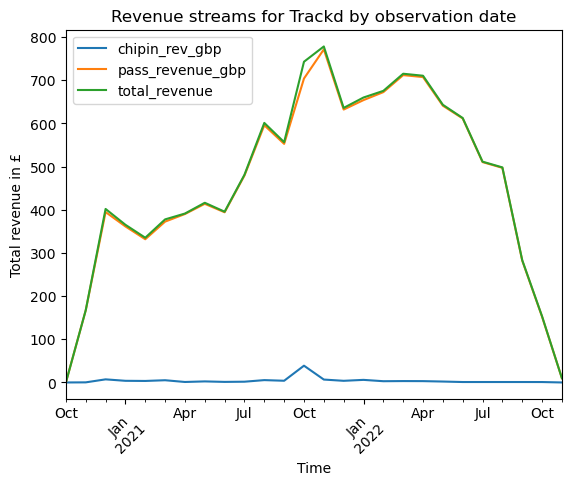

In [70]:
trackd_rev = df_users_up_obs_expanded.groupby(['observation_date']).sum()[['chipin_rev_gbp', 'pass_revenue_gbp', 'total_revenue']]

#fig, ax = plt.subplots()
ax = trackd_rev.plot(kind='line')
ax.set_title('Revenue streams for Trackd by observation date', size=12)
plt.xticks(rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Total revenue in £')
#ax.set_label(['Chip In, Chip In+'])
plt.savefig(output_folder + '/Trackd_revenue_over_time.png')
plt.show()

In [145]:
country_proportions =df_users_up_obs_expanded.groupby('country').size() / len(df_users_up_obs_expanded.dropna(subset=['country']))

# Apply the impute_country function to each row
df_users_up_obs_expanded['country'] = df_users_up_obs_expanded.apply(impute_country, axis=1)

popular_countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'India']

df_users_up_obs_expanded['country_new'] = 'rest of the world'

# Update the category for rows with countries in the top 5
df_users_up_obs_expanded.loc[df_users_up_obs_expanded['country'].isin(popular_countries), 'country_new'] = df_users_up_obs_expanded['country']
df_users_up_obs_expanded = df_users_up_obs_expanded.drop(columns=['country'])
df_users_up_obs_expanded.rename(columns={'country_new':'country'}, inplace=True)

/tmp/ipykernel_1515/136571362.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trackd_rev_country = df_users_up_obs_expanded.groupby(['observation_date','country']).sum()[['total_revenue']].unstack()


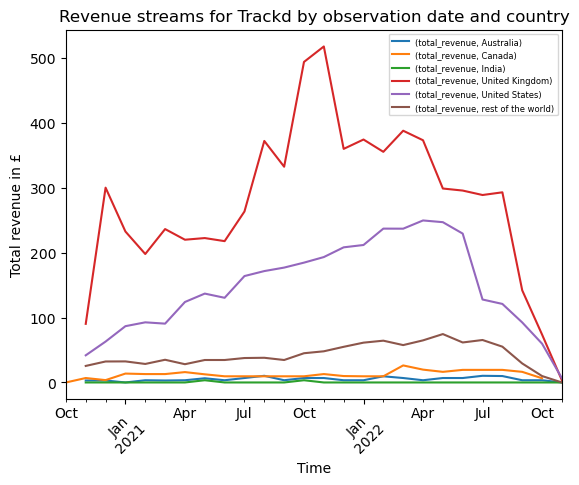

In [159]:
# Plot revenue streams by country
trackd_rev_country = df_users_up_obs_expanded.groupby(['observation_date','country']).sum()[['total_revenue']].unstack()

ax = trackd_rev_country.plot(kind='line')
ax.set_title('Revenue streams for Trackd by observation date and country', size=12)
plt.xticks(rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Total revenue in £')
#ax.set_label(['Chip In, Chip In+'])
plt.legend(loc='upper right', prop={'size': 6})
plt.savefig(output_folder + '/Trackd_revenue_over_time_by_country.png')
plt.show()

In [72]:
# Export financial table as csv file
#df_users_up_obs_expanded.to_csv('../Data/Financial_information_with_users.csv', index=False)

## Modelling

In [73]:
df_modelling_financial = df_users_up_obs_expanded[['user_id',
       'username', 'first_name', 'last_name', 'is_staff', 'is_active',
       'user_type', 'stripe_account_status','stripe_customer_status', 'email_verified',
       'locked','chipin_account_type', 'verified', 'country', 'last_login',
       'phone', 'occupation', 'facebook', 'instagram', 'snapchat', 'youtube', 'tiktok',
       'date_joined', 'months_subscribed', 'date_updated',
       'observation_date', 'pass_revenue', 'donation_made', 'interval',
       'status', 'made_by_id', 'currency', 'product_type',
       'song_id', 'chipin_rev', 'exchange_rate', 'chipin_rev_gbp', 'donation_received',
       'made_for_id', 'pass_revenue_billing', 'status_billing', 'currency_billing',
       'account_type_id_billing', 'total_pass_revenue','pass_revenue_gbp', 'total_revenue']]

In [74]:
df_modelling_financial.to_csv('../Data/Financial_modelling_dataset.csv', index=False)

In [79]:
financial_variables = ['user_id','pass_revenue', 'donation_made', 'chipin_rev', 'chipin_rev_gbp', 'donation_received',
       'pass_revenue_billing', 'total_pass_revenue','pass_revenue_gbp', 'total_revenue']

df_financial = df_modelling_financial.loc[:,financial_variables]
df_non_financial = df_modelling_financial.drop(financial_variables, axis=1)

In [80]:
# Group by user_id to convert to cross sectional
df_financial = df_financial.groupby('user_id').sum().reset_index(False)

df_non_financial = df_non_financial.groupby('user_id').agg('first').reset_index(False)

In [81]:
# Concatenate the tables
df_user = pd.concat([df_non_financial, df_financial], axis=1)

In [82]:
df_user = df_user.loc[:,~df_user.columns.duplicated()].copy()

In [83]:
df_user = df_user.loc[df_user.loc[:,'is_staff']==False]

### Derive days active for user variable

In [84]:
df_user_ip['timestamp'] = pd.to_datetime(df_user_ip['timestamp'],format='%Y-%m-%d %H:%M:%S.%f')
df_user_ip['date'] = df_user_ip['timestamp'].dt.date

# Remove multiple occurences of user ID in a single day due to small time difference
df_user_ip_drop_dup = df_user_ip.drop_duplicates(['user_id','date'], keep='first').copy()

df_user_ip_drop_dup['date'] = pd.to_datetime(df_user_ip_drop_dup['date'], format='%Y-%m-%d')
df_user_ip_drop_dup.set_index('date', inplace=True)

monthly_users = df_user_ip_drop_dup.resample('M')['user_id'].count()

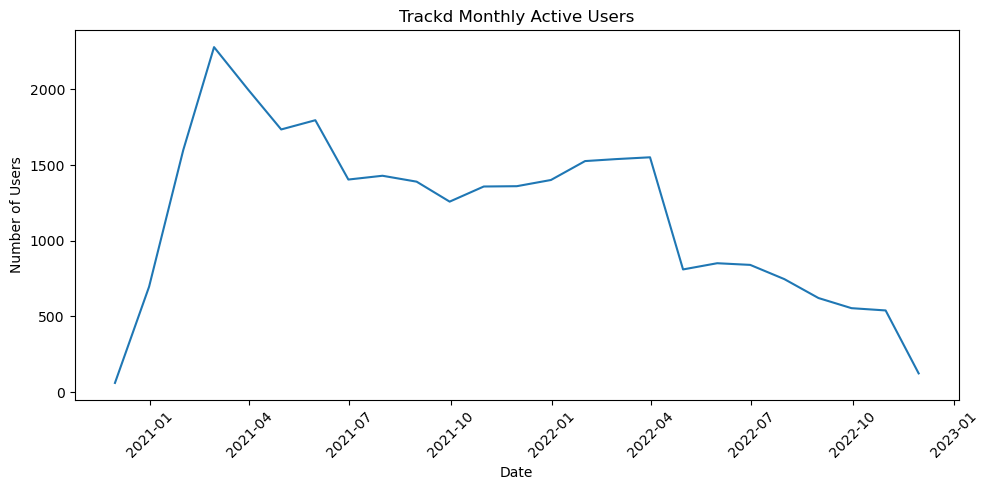

In [85]:
plt.figure(figsize=(10,5))
sns.lineplot(monthly_users)
plt.title('Trackd Monthly Active Users')
plt.ylabel('Number of Users')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
active_user_days = df_user_ip_drop_dup.value_counts('user_id')
active_user_days = pd.DataFrame(active_user_days, columns=['active_user_days'])

In [87]:
# Join active user days on df_user
df_user = df_user.merge(active_user_days, how='left',left_on='user_id', right_on=active_user_days.index)

In [88]:
# Features to ignore for modelling
df_modelling = df_user.drop(columns=['user_id', 'username', 'first_name', 'last_name', 'is_staff', 'is_active', 'stripe_account_status', 'stripe_customer_status','locked','verified','last_login','phone','date_joined','date_updated','observation_date', 'interval','status','made_by_id', 'currency','song_id', 'exchange_rate', 'made_for_id', 'status_billing', 'currency_billing', 'account_type_id_billing', 'pass_revenue', 'donation_made', 'chipin_rev', 'chipin_rev_gbp', 'donation_received', 'pass_revenue_billing','total_pass_revenue', 'pass_revenue_gbp','months_subscribed','active_user_days']) 

## Train test split

In [89]:
# Split the dataset into 80% train set and 20% test
train_set, test_set = train_test_split(df_modelling, train_size=0.8, random_state=7, shuffle=True)

In [90]:
for col in train_set.columns:
    print("Feature {} has {} missing values in the train set.".format(col,train_set[col].isnull().sum()))
    prop = train_set[col].isnull().sum()/len(train_set)
    print("The proportion of missing values is {}%.".format(round(prop * 100)))

Feature user_type has 139 missing values in the train set.
The proportion of missing values is 1%.
Feature email_verified has 0 missing values in the train set.
The proportion of missing values is 0%.
Feature chipin_account_type has 0 missing values in the train set.
The proportion of missing values is 0%.
Feature country has 12228 missing values in the train set.
The proportion of missing values is 85%.
Feature occupation has 14192 missing values in the train set.
The proportion of missing values is 99%.
Feature facebook has 5333 missing values in the train set.
The proportion of missing values is 37%.
Feature instagram has 5329 missing values in the train set.
The proportion of missing values is 37%.
Feature snapchat has 5416 missing values in the train set.
The proportion of missing values is 38%.
Feature youtube has 5374 missing values in the train set.
The proportion of missing values is 37%.
Feature tiktok has 36 missing values in the train set.
The proportion of missing values i

### Pre-processing and feature engineering

### Occupation

In [91]:
# Upon inspection of the values of the occupation variable, it makes no sense to include it as a predictor
# Because it is a free field and contains random words
# This column also has 99% missing values so best to leave it out
train_set['occupation'].value_counts()

Artist                                                                           20
                                                                                 11
Musician                                                                         10
Producer                                                                          6
musician                                                                          3
Songwriter                                                                        3
Student                                                                           3
Singer/Songwriter                                                                 2
DJ/Producer                                                                       2
Music Artist                                                                      2
Singer songwriter                                                                 2
Retired                                                                     

### User type

In [92]:
# For user type, there is no logical way to infer what the missing values would have been as well as those with whitespace value
# Therefore, we decide to exclude them entirely from the modelling
train_set = train_set.loc[train_set.loc[:,'user_type']!=""]
train_set.dropna(axis=0, subset='user_type', inplace=True)

test_set = test_set.loc[test_set.loc[:,'user_type']!=""]
test_set.dropna(axis=0, subset='user_type', inplace=True)

### Country

**Assumption**: Users with missing country have the same distribution as those with a country in the train and test datasets

In [93]:
country_proportions =train_set.groupby('country').size() / len(train_set.dropna(subset=['country']))

# Apply the impute_country function to each row
train_set['country'] = train_set.apply(impute_country, axis=1)
test_set['country'] = test_set.apply(impute_country, axis=1)

In [94]:
# The rate of missing country is too large to just drop the cases (85%)
# Instead what we will do is we will keep the 5 most popular countries and group all the rest into a "Rest of world" category
# For the missing cases, we will just impute them as if the proportions would have stayed the same
popular_countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'India']

train_set['country_new'] = 'rest of the world'
test_set['country_new'] = 'rest of the world'

# Update the category for rows with countries in the top 5
train_set.loc[train_set['country'].isin(popular_countries), 'country_new'] = train_set['country']
train_set = train_set.drop(columns=['country'])
train_set.rename(columns={'country_new':'country'}, inplace=True)

test_set.loc[test_set['country'].isin(popular_countries), 'country_new'] = test_set['country']
test_set = test_set.drop(columns=['country'])
test_set.rename(columns={'country_new':'country'}, inplace=True)

###  Social media variables

In [95]:
train_set['has_facebook'] = np.where(train_set['facebook'].isnull(), 0, 1)
train_set['has_instagram'] = np.where(train_set['instagram'].isnull(), 0, 1)
train_set['has_snapchat'] = np.where(train_set['snapchat'].isnull(), 0, 1)
train_set['has_youtube'] = np.where(train_set['youtube'].isnull(), 0, 1)
train_set['has_tiktok'] = np.where(train_set['tiktok'].isnull(), 0, 1)

test_set['has_facebook'] = np.where(test_set['facebook'].isnull(), 0, 1)
test_set['has_instagram'] = np.where(test_set['instagram'].isnull(), 0, 1)
test_set['has_snapchat'] = np.where(test_set['snapchat'].isnull(), 0, 1)
test_set['has_youtube'] = np.where(test_set['youtube'].isnull(), 0, 1)
test_set['has_tiktok'] = np.where(test_set['tiktok'].isnull(), 0, 1)

### Email verified

In [96]:
train_set['email_verified'] = np.where(train_set['email_verified']==True,1,0)
test_set['email_verified'] = np.where(test_set['email_verified']==True,1,0)

## Target variable : log(total_revenue)

In [97]:
# Target variable will be log of total_revenue to prevent the predictions being negative
# We will then convert back to the original variable to compare the accuracy
y_train = pd.DataFrame(train_set['total_revenue'])
y_train['log_total_revenue'] = np.log(y_train['total_revenue']+1)
y_test = pd.DataFrame(test_set['total_revenue'])
y_test['log_total_revenue'] = np.log(y_test['total_revenue']+1)

X_train = train_set.loc[:,train_set.columns!='total_revenue']
X_test = test_set.loc[:,test_set.columns!='total_revenue']

In [98]:
# We are going to keep the final list of pre-processed features for the modelling
X_train = X_train[['user_type', 'chipin_account_type', 'country','email_verified', 'has_facebook', 'has_instagram', 'has_snapchat', 'has_youtube', 'has_tiktok']]
X_test = X_test[['user_type', 'chipin_account_type', 'country','email_verified', 'has_facebook', 'has_instagram', 'has_snapchat', 'has_youtube', 'has_tiktok']]

In [99]:
# Export the modelling datasets
train_set.to_csv("../Data/Financial_training_sample.csv",index=False)
test_set.to_csv("../Data/Financial_test_sample.csv",index=False)

### Apply one-hot encoding

In [100]:
X_train = pd.get_dummies(X_train, columns=['user_type', 'chipin_account_type', 'country'],drop_first=True)
X_test = pd.get_dummies(X_test, columns=['user_type', 'chipin_account_type', 'country'],drop_first=True)

## Model 1: Unconstrained linear regression

In [101]:
#from sklearn.linear_model import LinearRegression
LR_model = LinearRegression(fit_intercept= True)
LR_model.fit(X_train, y_train['log_total_revenue'])

# Predict on train set
y_train['predicted_total_revenue_log'] = LR_model.predict(X_train)
y_train['predicted_total_revenue_ols'] = np.exp(y_train['predicted_total_revenue_log'])
y_train['error_ols'] = y_train['total_revenue'] - y_train['predicted_total_revenue_ols']

# Predict on test set
y_test['predicted_total_revenue_log'] = LR_model.predict(X_test)
y_test['predicted_total_revenue_ols'] = np.exp(y_test['predicted_total_revenue_log'])
y_test['error_ols'] = y_test['total_revenue'] - y_test['predicted_total_revenue_ols']

In [102]:
# Print the intercept and model coefficients
print(LR_model.intercept_)
print(LR_model.coef_)

3.358689758928455
[ 9.57477805e-03 -9.56972919e-02  3.96304430e-01 -6.66742647e-01
  3.53917137e-01  2.21951668e-01  4.51086455e-03 -3.06808101e-01
 -3.59077873e+00 -6.97718186e-04  2.30448553e-03  1.71919943e-02
  9.98440150e-03  1.04184788e-02]


In [122]:
# Print the RMSE on train and test sets
mse_OLS_train = mean_squared_error(y_train['total_revenue'], y_train['predicted_total_revenue_ols'], squared=False)
print("The RMSE of the linear model on the train set is {}.".format(mse_OLS_train))

mse_OLS_test = mean_squared_error(y_test['total_revenue'], y_test['predicted_total_revenue_ols'], squared=False)
print("The RMSE of the linear model on the test set is {}.".format(mse_OLS_test))

The RMSE of the linear model on the train set is 7.308468384853272.
The RMSE of the linear model on the test set is 4.336131085962976.


In [104]:
# Let's produce the summary table using the statsmodels package
X_train_ols = sm.add_constant(X_train)
OLS_model=OLS(y_train['log_total_revenue'],X_train_ols).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_total_revenue   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.362e+04
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:52:23   Log-Likelihood:                 10451.
No. Observations:               12781   AIC:                        -2.087e+04
Df Residuals:                   12766   BIC:                        -2.076e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               3.3587      0.030    112.992      0.000       3.300       3.417
email_verified                      0.0096      0.003      3.119      0.002       0.004       0.016
has_facebook                       -0.0957      0.040     -2.400      0.016      -0.174      -0.018
has_instagram                       0.3963      0.040      9.986      0.000       0.319       0.474
has_snapchat                       -0.6667      0.020    -34.031      0.000      -0.705      -0.628
has_youtube                         0.3539      0.024     14.761      0.000       0.307       0.401
has_tiktok                          0.2220      0.026      8.686      0.000       0.172       0.272
user_type_discover                  0.0045      0.003      1.703      0.089      -0.001       0.010
chipin_account_type_chipin_plus    -0.3068      0.017    -18.594      0.000      -0.339      -0.274
chipin_account_type_not_enabled    -3.5908      0.012   -296.760      0.000      -3.614      -3.567
country_Canada                     -0.0007      0.006     -0.110      0.912      -0.013       0.012
country_India                       0.0023      0.009      0.261      0.794      -0.015       0.020
country_United Kingdom              0.0172      0.005      3.616      0.000       0.008       0.027
country_United States               0.0100      0.005      2.122      0.034       0.001       0.019
country_rest of the world           0.0104      0.005      1.928      0.054      -0.000       0.021
==============================================================================
Omnibus:                     9262.332   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         36056489.052
Skew:                          -1.822   Prob(JB):                         0.00
Kurtosis:                     263.179   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predicted vs actual plots

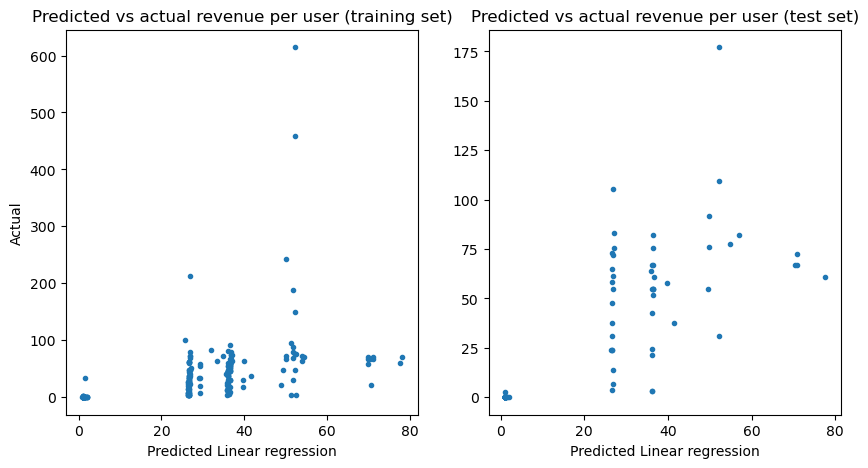

In [105]:
# Scatterplot of predictions vs actuals
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first scatterplot on the left subplot
axs[0].scatter(y_train['predicted_total_revenue_ols'], y_train['total_revenue'], marker='.')
axs[0].set_xlabel('Predicted Linear regression')
axs[0].set_ylabel('Actual')
axs[0].set_title('Predicted vs actual revenue per user (training set)')

# Plot the second scatterplot on the right subplot
axs[1].scatter(y_test['predicted_total_revenue_ols'], y_test['total_revenue'], marker='.')
axs[1].set_title('Predicted vs actual revenue per user (test set)')
axs[1].set_xlabel('Predicted Linear regression')

# Display the figure
plt.savefig("../Output/Predicted vs actual revenue linear regression model")
plt.show()

## Model 2: Linear regression model with Ridge regularisation

In [106]:
# Defining the set of lambda parameters
lambda_list = np.logspace(-5.0, 5.0, num=10)
print(lambda_list)

# Defining the number of folds to use in k-fold cross-validation
no_folds = 10

[1.00000000e-05 1.29154967e-04 1.66810054e-03 2.15443469e-02
 2.78255940e-01 3.59381366e+00 4.64158883e+01 5.99484250e+02
 7.74263683e+03 1.00000000e+05]


In [107]:
# Applying the cross-validation function to select the optimal lambda parameter
target =y_train['log_total_revenue']
errors_validation = cross_validation(X_train, target, lambda_list, no_folds, regulariser=Ridge)
best_lambda = lambda_list[np.argmin(errors_validation)]

In [114]:
# Select the best Ridge model, fit on train+validation and predict on the test set
Ridge_model = Ridge(alpha=best_lambda)
Ridge_model.fit(X_train, target)

# Predict on train set
y_train['predicted_total_revenue_ridge_log'] = Ridge_model.predict(X_train)
y_train['predicted_total_revenue_ridge'] = np.exp(y_train['predicted_total_revenue_ridge_log'])
y_train['error_ridge'] = y_train['total_revenue'] - y_train['predicted_total_revenue_ridge']

# Predict on test set
y_test['predicted_total_revenue_ridge_log'] = Ridge_model.predict(X_test)
y_test['predicted_total_revenue_ridge'] = np.exp(y_test['predicted_total_revenue_ridge_log'])
y_test['error_ridge'] = y_test['total_revenue'] - y_test['predicted_total_revenue_ridge']

In [116]:
# Print the RMSE on train and test sets
mse_Ridge_train = mean_squared_error(y_train['total_revenue'], y_train['predicted_total_revenue_ridge'], squared=False)
print("The RMSE of the Ridge model on the train set is {}.".format(mse_Ridge_train))

mse_Ridge_test = mean_squared_error(y_test['total_revenue'], y_test['predicted_total_revenue_ridge'], squared=False)
print("The RMSE of the Ridge model on the test set is {}.".format(mse_Ridge_test))

The RMSE of the Ridge model on the train set is 7.313080702145516.
The RMSE of the Ridge model on the test set is 4.3460064083504575.


In [117]:
# Check which features the Ridge model reduced in magnitude
keys=X_train.columns
val=Ridge_model.coef_
ridge_coef = dict(zip(keys,val))
print(ridge_coef)

{'email_verified': 0.009734823948257547, 'has_facebook': -0.08422266610349703, 'has_instagram': 0.38690587332535253, 'has_snapchat': -0.6608162912847017, 'has_youtube': 0.34584837090757364, 'has_tiktok': 0.21808910218854927, 'user_type_discover': 0.004459163040874485, 'chipin_account_type_chipin_plus': -0.2934053580448095, 'chipin_account_type_not_enabled': -3.5787785671058168, 'country_Canada': -0.0006304610684620248, 'country_India': 0.0022576428437526062, 'country_United Kingdom': 0.01724019390312884, 'country_United States': 0.010025847600227898, 'country_rest of the world': 0.010508785714289226}


### Predicted vs actuals plots

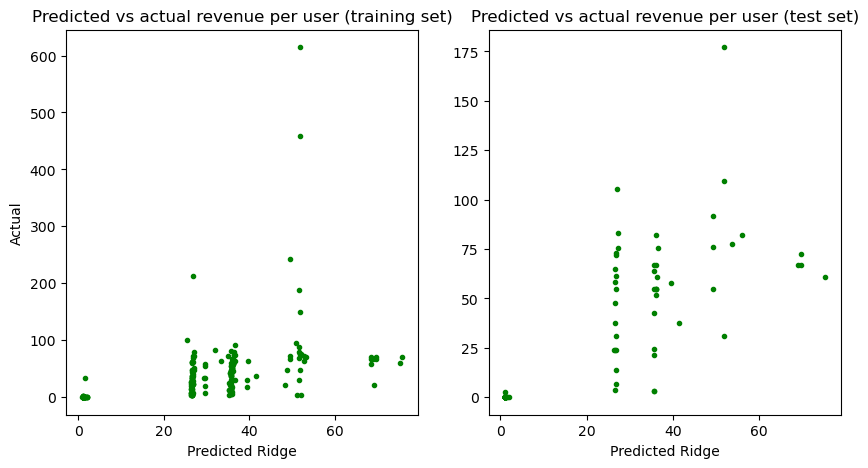

In [118]:
# Scatterplot of predictions vs actuals
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first scatterplot on the left subplot
axs[0].scatter(y_train['predicted_total_revenue_ridge'], y_train['total_revenue'], marker='.', c='g')
axs[0].set_xlabel('Predicted Ridge')
axs[0].set_ylabel('Actual')
axs[0].set_title('Predicted vs actual revenue per user (training set)')

# Plot the second scatterplot on the right subplot
axs[1].scatter(y_test['predicted_total_revenue_ridge'], y_test['total_revenue'], marker='.', c='g')
axs[1].set_title('Predicted vs actual revenue per user (test set)')
axs[1].set_xlabel('Predicted Ridge')

# Display the figure
plt.savefig("../Output/Predicted vs actual revenue Ridge regression model")
plt.show()

## Model 3: LASSO regression

In [119]:
# Repeat the same procedure as for Ridge by conducting a kfold validation to select the optimal lambda parameter
errors_validation = cross_validation(X_train, target, lambda_list, no_folds, regulariser=Lasso)
best_lambda = lambda_list[np.argmin(errors_validation)]

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e+01, tolerance: 2.052e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e+01, tolerance: 2.177e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

In [120]:
# Select the best Lasso model, fit on train+validation and predict on the test set
Lasso_model = Lasso(alpha=best_lambda)
Lasso_model.fit(X_train, target)

# Predict on train set
y_train['predicted_total_revenue_lasso_log'] = Lasso_model.predict(X_train)
y_train['predicted_total_revenue_lasso'] = np.exp(y_train['predicted_total_revenue_lasso_log'])
y_train['error_ridge'] = y_train['total_revenue'] - y_train['predicted_total_revenue_lasso']

# Predict on test set
y_test['predicted_total_revenue_lasso_log'] = Lasso_model.predict(X_test)
y_test['predicted_total_revenue_lasso'] = np.exp(y_test['predicted_total_revenue_lasso_log'])
y_test['error_lasso'] = y_test['total_revenue'] - y_test['predicted_total_revenue_lasso']

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+01, tolerance: 2.324e-01
  model = cd_fast.enet_coordinate_descent(


In [121]:
# Print the RMSE on train and test sets
mse_Lasso_train = mean_squared_error(y_train['total_revenue'], y_train['predicted_total_revenue_lasso'], squared=False)
print("The RMSE of the LASSO model on the train set is {}.".format(mse_Lasso_train))

mse_Lasso_test = mean_squared_error(y_test['total_revenue'], y_test['predicted_total_revenue_lasso'], squared=False)
print("The RMSE of the LASSO model on the test set is {}.".format(mse_Lasso_test))

The RMSE of the LASSO model on the train set is 7.311313310405091.
The RMSE of the LASSO model on the test set is 4.34256725122976.


In [118]:
# Check which features the Lasso model has forced to zero
keys=X_train.columns
val=Lasso_model.coef_
lasso_coef = dict(zip(keys,val))
print(lasso_coef)

{'email_verified': 0.2961672181741273, 'has_facebook': 0.0, 'has_instagram': 11.90740549693043, 'has_snapchat': -27.996394285268707, 'has_youtube': 15.646973589803151, 'has_tiktok': 7.375457463197622, 'user_type_creator': -0.0, 'user_type_discover': 0.0, 'chipin_account_type_chipin': 0.0, 'chipin_account_type_chipin_plus': 0.0, 'chipin_account_type_not_enabled': -43.913294597432944, 'country_Australia': -0.0, 'country_Canada': -0.0, 'country_India': 0.0, 'country_United Kingdom': 0.3427685991302871, 'country_United States': -0.0, 'country_rest of the world': -0.0}


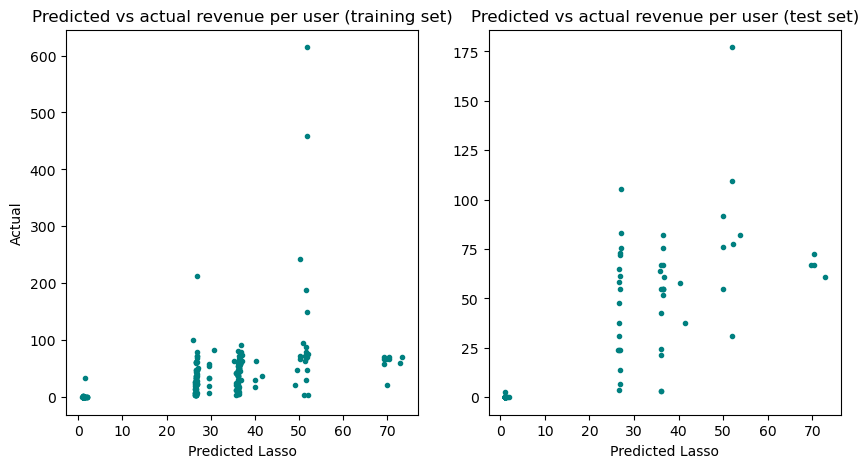

In [123]:
# Scatterplot of predictions vs actuals
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first scatterplot on the left subplot
axs[0].scatter(y_train['predicted_total_revenue_lasso'], y_train['total_revenue'], marker='.', c='teal')
axs[0].set_xlabel('Predicted Lasso')
axs[0].set_ylabel('Actual')
axs[0].set_title('Predicted vs actual revenue per user (training set)')

# Plot the second scatterplot on the right subplot
axs[1].scatter(y_test['predicted_total_revenue_lasso'], y_test['total_revenue'], marker='.', c='teal')
axs[1].set_title('Predicted vs actual revenue per user (test set)')
axs[1].set_xlabel('Predicted Lasso')

# Display the figure
plt.savefig("../Output/Predicted vs actual revenue Lasso regression model")
plt.show()

In [139]:
# Create a table of the MSE metrics
metrics = [mse_OLS_train,  mse_Ridge_train, mse_Lasso_train, mse_OLS_test, mse_Ridge_test, mse_Lasso_test]
metrics = np.array(metrics).reshape(2,3)
performance_table = pd.DataFrame(data= metrics, columns=['Linear Regression', 'Ridge', 'Lasso'], index=['Training','Test'])
display(performance_table)

,Linear Regression,Ridge,Lasso
Training,7.3085,7.3131,7.3113
Test,4.3361,4.3460,4.3426
